# Project Topic
To receive full credit for this section, the learner should address the two questions below:
- Is there a clear explanation of what this project is about? 
- Does it give a clear description of generative deep learning models including Generative Adversarial Networks (GANs)?








This project is about generating images in the style of Monet.

Generative Adversarial Networks (GANs) are a type of machine learning framework invented by Ian Goodfellow and his team in 2014. At their core, GANs consist of two neural networks, a generator and a discriminator, that work in competition with each other to produce data that closely resembles real-world examples.

Here's how the two networks work:

Generator: This network creates synthetic data, such as images, audio, or text, from random noise. Its goal is to generate outputs that are indistinguishable from real data.

Discriminator: This network evaluates data, distinguishing between the real data (from a training set) and the fake data produced by the generator.

These two networks are trained simultaneously:

The generator improves by learning to produce data that can "fool" the discriminator.

The discriminator improves by getting better at identifying fake data.

This adversarial process continues until the generator produces data so realistic that the discriminator can no longer reliably tell it apart from real data.

# Data & Exploratory Data Analysis 
- Is there a clear description of the data, including the size, dimension, and structure? Some ideas for image data: you can include how many samples, number of channels (color or gray or more?) or modalities, image file format, whether images have the same dimension or not, etc.
- EDA on images is open-ended, and it can be as simple as picking a few samples of images from each class, displaying them, and describing any findings. Some more ideas: you could plot histograms of those sample images and draw any conclusions. You could summarize image similarity by choosing a single metric to compare. The data may or may not have different image sizes, but you could mention that if the image sizes are different. Also, you can check how the range of the pixel intensities is distributed. You may also count labels (if multi-class or multi-label classification problem) to see if the labels are skewed, or you can plot a histogram of areas by segmentation labels, etc.
10 pts
- EDA goes above and beyond expectations: for example, in addition to picking a few sample images from each class, displaying them, and describing any findings, the learner includes several other histograms, appropriate visualizations, and detailed analysis of the dataset.









In [17]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import keras
import tensorflow as tf
from sentence_transformers import SentenceTransformer, util

# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing the data and how many images we have and what they look like. They're all in the `.jpg` or `.tfrec` format. Monet paintings will be what we're trying to replicate.

In [18]:
# Import and see how many we have
monet_jpgs = glob.glob("gan-getting-started/monet_jpg/*.jpg")
print(f'Total number of Monet images: {len(monet_jpgs)}')

Total number of Monet images: 300


In [3]:
monet_tfrecs = glob.glob("gan-getting-started/monet_tfrec/*.tfrec")
print(f'Total number of Monet tfrecs: {len(monet_tfrecs)}')

Total number of Monet tfrecs: 5


The photos that we will convert to Monet paintings.

In [4]:
photo_jpgs = glob.glob("gan-getting-started/photo_jpg/*.jpg")
print(f'Total number of Photo images: {len(photo_jpgs)}')
photo_tfrecs = glob.glob("gan-getting-started/photo_tfrec/*.tfrec")
print(f'Total number of Photo tfrecs: {len(photo_tfrecs)}')

Total number of Photo images: 7038
Total number of Photo tfrecs: 20


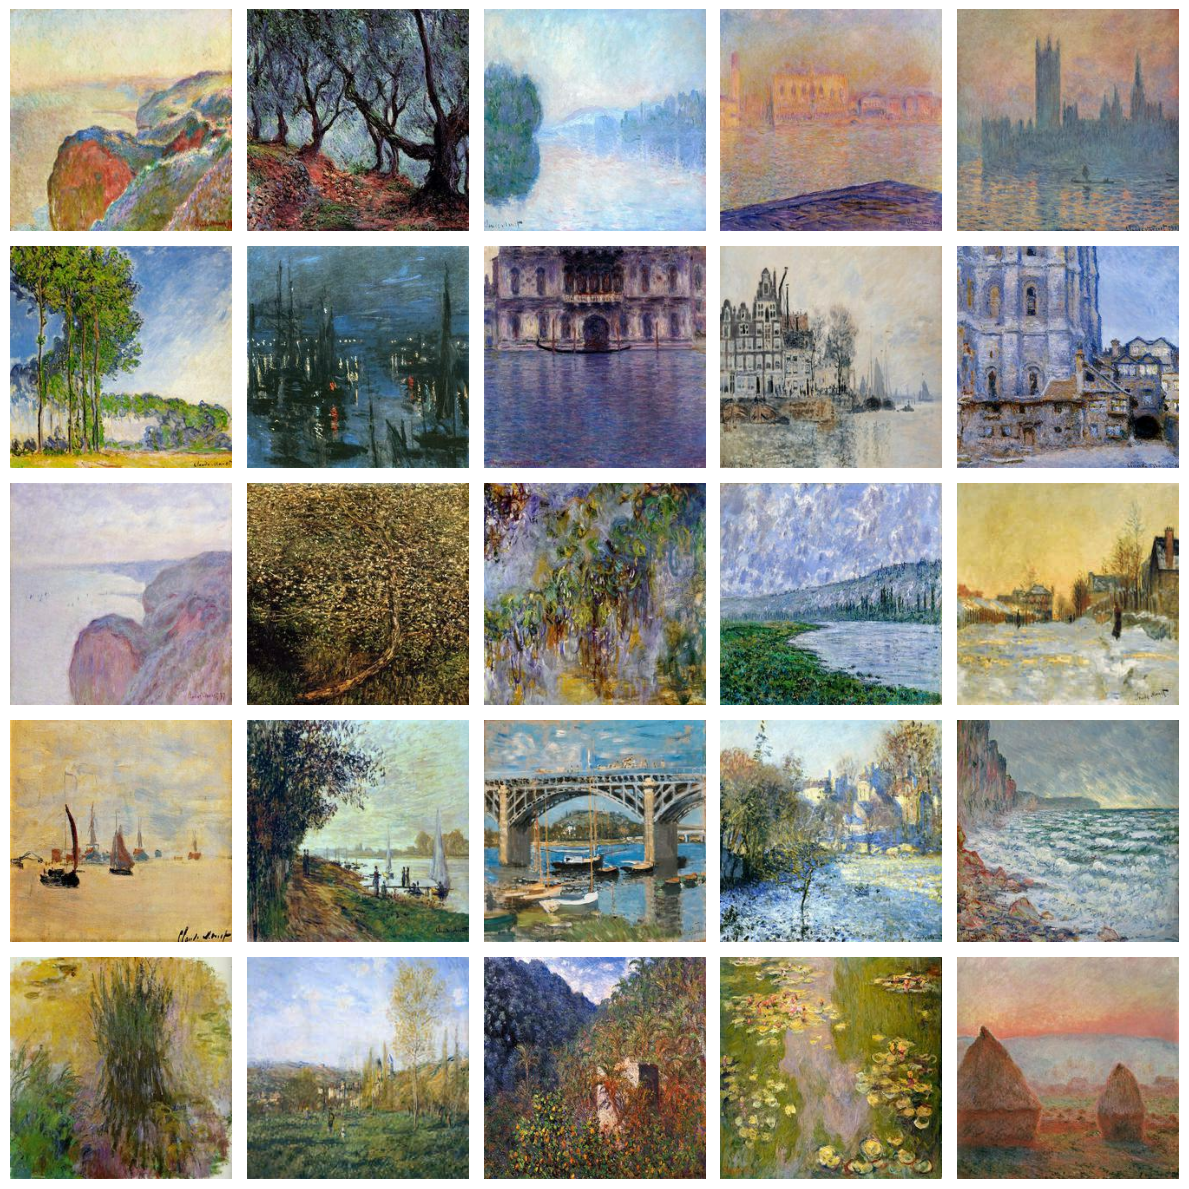

In [5]:
# Display what the images look like
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for ax, image_path in zip(axes.flatten(), monet_jpgs[:25]):
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis("off")
plt.tight_layout()
plt.show()

Sizes of the images, they turned out to all be 256x256.

In [6]:
image_sizes = []

for image_path in monet_jpgs:
    image = Image.open(image_path)
    image_sizes.append(image.size)

df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

print(df_sizes.head())

df_sizes.describe()

   Width  Height
0    256     256
1    256     256
2    256     256
3    256     256
4    256     256


Width  Height
count  300.0   300.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0

RGB Values of an original image. If we're going to fake similar styles, we probably need to have similar RGB values.

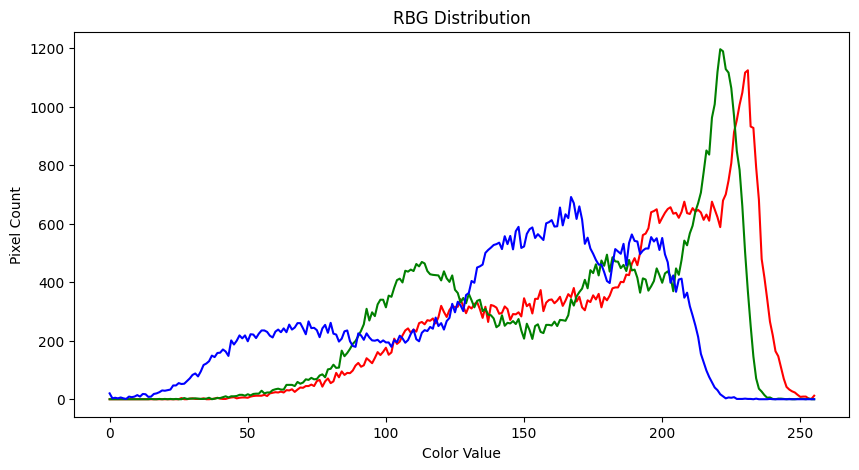

In [7]:
image = cv2.imread(monet_jpgs[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
color = ("r", "g", "b")
for i, col in enumerate(color):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)

plt.title("RBG Distribution")
plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.show()

# Check for duplicate images
Are there any duplicate images? We can use OpenAi's CLIP model which is a pre-trained model to find duplicates/near-duplicates of images. 

In [8]:
# Originally from https://stackoverflow.com/a/71567609
# Load the OpenAI CLIP Model
model = SentenceTransformer('clip-ViT-B-32')

# Converting them to vector space
encoded_image = model.encode([Image.open(filepath) for filepath in monet_jpgs], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images aganist
# all other images and returns a list with the pairs that have the highest
# cosine similarity score
processed_images = util.paraphrase_mining_embeddings(encoded_image)
NUM_SIMILAR_IMAGES = 10

# =================
# DUPLICATES
# =================
print("Finding duplicate images...")
# Filter list for duplicates. Results are triplets (score, image_id1, image_id2) and is scorted in decreasing order
# A duplicate image will have a score of 1.00
duplicates = [image for image in processed_images if image[0] >= 1]

# Output the top X duplicate images
for score, image_id1, image_id2 in duplicates[0:NUM_SIMILAR_IMAGES]:
    print("\nScore: {:.3f}%".format(score * 100))
    print(monet_jpgs[image_id1])
    print(monet_jpgs[image_id2])

# =================
# NEAR DUPLICATES
# =================
print("Finding near duplicate images...")
# Use a threshold parameter to identify two images as similar. By setting the threshold lower,
# you will get larger clusters which have less similar images in it. Threshold 0 - 1.00
# A threshold of 1.00 means the two images are exactly the same. Since we are finding near
# duplicate images, we can set it at 0.99 or any number 0 < X < 1.00.
threshold = 0.99
near_duplicates = [image for image in processed_images if image[0] < threshold]

for score, image_id1, image_id2 in near_duplicates[0:NUM_SIMILAR_IMAGES]:
    print("\nScore: {:.3f}%".format(score * 100))
    print(monet_jpgs[image_id1])
    print(monet_jpgs[image_id2])


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Finding duplicate images...
Finding near duplicate images...

Score: 97.388%
gan-getting-started/monet_jpg/eb3cc5c559.jpg
gan-getting-started/monet_jpg/fb806a2a1c.jpg

Score: 97.045%
gan-getting-started/monet_jpg/9908d1daa9.jpg
gan-getting-started/monet_jpg/fba982625d.jpg

Score: 96.526%
gan-getting-started/monet_jpg/4c0e35882c.jpg
gan-getting-started/monet_jpg/7239ba0b55.jpg

Score: 96.216%
gan-getting-started/monet_jpg/05144e306f.jpg
gan-getting-started/monet_jpg/2e0d0e6e19.jpg

Score: 95.798%
gan-getting-started/monet_jpg/68b60c04b7.jpg
gan-getting-started/monet_jpg/f4413e97bd.jpg

Score: 95.610%
gan-getting-started/monet_jpg/b1ea5d5a7d.jpg
gan-getting-started/monet_jpg/ede9769cb3.jpg

Score: 95.397%
gan-getting-started/monet_jpg/05144e306f.jpg
gan-getting-started/monet_jpg/ede9769cb3.jpg

Score: 95.385%
gan-getting-started/monet_jpg/3843e221cc.jpg
gan-getting-started/monet_jpg/d239dae42d.jpg

Score: 95.162%
gan-getting-started/monet_jpg/158740962c.jpg
gan-getting-started/monet_jpg/

From our given images, some are pretty similar as seen below.

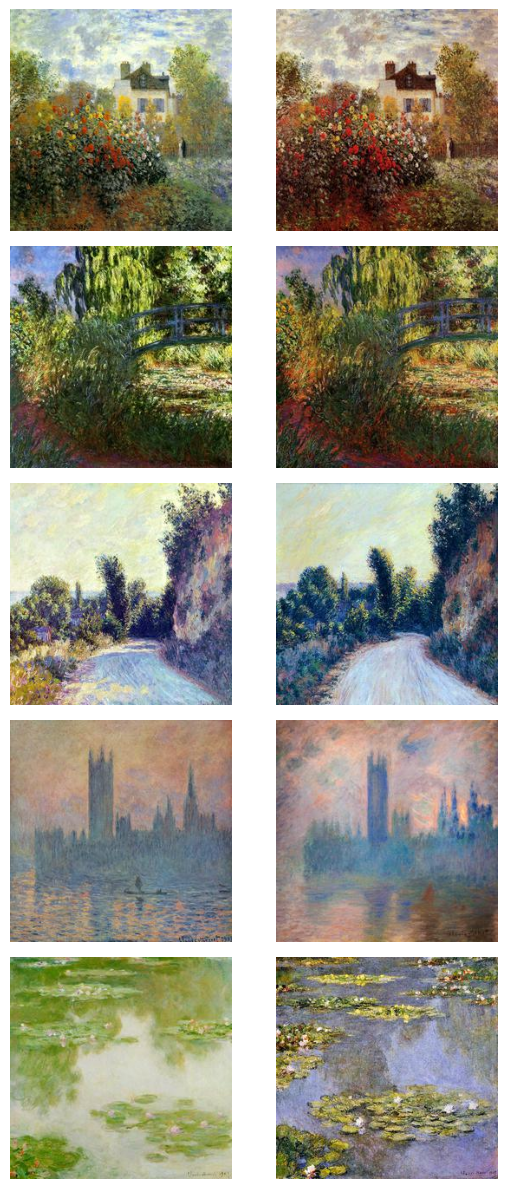

In [9]:
scores = []
image_similar_paths = []
for score, image_id1, image_id2 in near_duplicates[0:NUM_SIMILAR_IMAGES]:
    scores.append(score)
    image_similar_paths.append(monet_jpgs[image_id1])
    image_similar_paths.append(monet_jpgs[image_id2])

fig, axes = plt.subplots(5, 2, figsize=(6, 12))
for ax, image_path in zip(axes.flatten(), image_similar_paths):
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis("off")
plt.tight_layout()
plt.show()


# Model Architecture
- Does it describe the model architecture and explain why the learner believes a specific architecture/loss function is suitable for the problem? 
- Did the learner tune the hyperparameters? 
- Did the learner compare multiple architectures/loss functions?
- Note, when you evaluate, don't just base your score on the complexity of the model/technique or performance of the model alone. Base your score on how the learner demonstrates understanding by explaining the concepts and why they chose particular methods/techniques.



Cool, all the Monet paintings are 256x256 pixels and have 300 images to sample from. Some of those images are pretty similar. The general RGB distribution shows us the colors tend to be pastel and have a rather high pixel count. We can now use this information against our generated images to see how similar they are to create a GAN model to make enough fake Monet images. 

I'm planning on creating a `CycleGAN` which is an approach to training a deep convolution neural network for image-to-image translation tasks

In [ ]:
# Assisted from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
# I try my best to explain what each part is doing in my own words.
OUTPUT_CHANNELS = 3

def down_sample(filters, size, apply_instancenorm=True):
    """
    Reduces the 2D dimensions, the width and height, of the image by the stride.
    The stride is the length of the step the filter takes. Since the stride is
    2, the filter is applied to every other pixel, hence reducing the weight and
    height by 2.

    We'll be using a GroupNormalization instead of batch normalization.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(keras.layers.GroupNormalization(gamma_initializer=gamma_init))

    result.add(keras.layers.LeakyReLU())

    return result

def up_sample(filters, size, apply_dropout=False):
    """
    Increases the dimensions of the of the image. Conv2DTranspose does basically
    the opposite of a Conv2D layer - doing the opposite of down_sample.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(keras.layers.GroupNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(keras.layers.Dropout(0.5))

    result.add(keras.layers.ReLU())

    return result

# The Generator
The generator begins by reducing the resolution of the input image through downsampling, followed by upsampling while incorporating long skip connections. These skip connections address the vanishing gradient problem by linking the output of a layer to several subsequent layers, rather than a single one. In this process, the output of the downsampling layer is symmetrically concatenated with the upsampling layer. 

Skip connections offer several advantages in neural networks, particularly in tasks like image processing and deep learning. A key benefit include the mitigation of vanishing gradients which is done by connecting earlier layers directly to later ones, facilitating smoother training of very deep networks. Another benefit is greater accuracy by preserving fine details and bypassing unnecessary transformations, contributing to better performance and higher accuracy in tasks like image segmentation and restoration.

In [11]:
def Generator():
    inputs = keras.layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        down_sample(128, 4), # (bs, 64, 64, 128)
        down_sample(256, 4), # (bs, 32, 32, 256)
        down_sample(512, 4), # (bs, 16, 16, 512)
        down_sample(512, 4), # (bs, 8, 8, 512)
        down_sample(512, 4), # (bs, 4, 4, 512)
        down_sample(512, 4), # (bs, 2, 2, 512)
        down_sample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        up_sample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        up_sample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        up_sample(512, 4), # (bs, 16, 16, 1024)
        up_sample(256, 4), # (bs, 32, 32, 512)
        up_sample(128, 4), # (bs, 64, 64, 256)
        up_sample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# The Discriminator
The discriminator checks the input image to see if it’s real or fake. Instead of giving just one result, it produces a smaller 2D image, where higher pixel values mean the image is real, and lower values mean it’s fake. With regards to GANs again, the discriminator’s classification results are used to *improve* the generator. If the discriminator correctly identifies a fake sample, the generator receives feedback to adjust its parameters and produce more convincing data in the future.

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = down_sample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = down_sample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = down_sample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = keras.layers.GroupNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = keras.layers.LeakyReLU()(norm1)

    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = keras.layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return keras.Model(inputs=inp, outputs=last)

In [ ]:
monet_generator = Generator() # transforms photos to Monet-fakes paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

Preprocessing our data for our model. Since these are RGB images, we'll configure the channel to 3. Additionally, adjust the images to fall within the [-1, 1] range. Because the task involves building a generative model, the labels and image IDs are not needed, so only the image will be retrieved from the TFRecord.

In [ ]:
BATCH_SIZE = 1 # CycleGAN typically works with batch_size=1.
BUFFER_SIZE = 1000
EPOCHS = 100
WEIGHT = 10 # Weight for cycle consistency and identity loss

In [26]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [27]:
monet_ds = load_dataset(monet_tfrecs, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrecs, labeled=True).batch(1)

In [28]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

2025-04-17 23:36:56.495979: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144


Our custom `CycleGan`, it inherits from the Keras model and builds upon it.

In [30]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss Functions

In [31]:
def discriminator_loss(real, generated):
    """
    The discriminator loss function evaluates real images by comparing them to a
    matrix of 1s, and fake images by comparing them to a matrix of 0s. An ideal
    discriminator would produce outputs of all 1s for real images and all 0s for
    fake ones. The loss function calculates the average of the losses from real
    and generated images.
    """
    real_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=None)(tf.ones_like(real), real)

    generated_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=None)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss / 2

def generator_loss(generated):
    """
    The generator aims to deceive the discriminator into classifying the
    generated image as real. An ideal generator would cause the discriminator to
    output only 1s. To calculate the loss, it compares the generated image to a
    matrix of 1s.
    """
    return keras.losses.BinaryCrossentropy(from_logits=True, reduction=None)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    """
    Calculate the cycle consistency loss by averaging their differences.
    """
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    """
    Evaluates the similarity between an image and its generator
    (e.g., a photo and its corresponding photo generator). When a photo is
    provided as input, the goal is for the generator to reproduce the same
    image, maintaining its original characteristics. Identity loss measures the
    difference between the input and the generator's output.
    """
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Hyperparameter Tuning
I plan on starting with a learning rate of 0.0002 for the Adam optimizer and a batch size of 1 and then slowly increasing/decreasing it by a magnitude of 10s. Then I adjusted the regularization methods via weight decay or dropout. 
Changing the learning rate to be a higher value ended up getting fake images that didn't look all too different. This is most likely because it ended up overfitting and generalizing the images incorrectly. I get more grainy/Monet-looking images by turning the epochs way up and I believe this is because the model to trained more.

In [37]:
monet_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

In [49]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.5814 - photo_disc_loss: 0.5679 - photo_gen_loss: 2.7244
Epoch 2/50


2025-04-18 08:45:23.119670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17628809205173995779
2025-04-18 08:45:23.119776: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9925355512907006977
/home/basilp/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.5590 - photo_disc_loss: 0.5698 - photo_gen_loss: 2.7266
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.4696 - photo_disc_loss: 0.5879 - photo_gen_loss: 2.6058
Epoch 4/50


2025-04-18 08:46:00.255985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17628809205173995779
2025-04-18 08:46:00.256014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9925355512907006977


300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 2.5227 - photo_disc_loss: 0.5725 - photo_gen_loss: 2.6736
Epoch 5/50


2025-04-18 08:46:17.959784: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.5611 - photo_disc_loss: 0.5753 - photo_gen_loss: 2.7114
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.5123 - photo_disc_loss: 0.5750 - photo_gen_loss: 2.6644
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.5042 - photo_disc_loss: 0.5751 - photo_gen_loss: 2.6724
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.5049 - photo_disc_loss: 0.5703 - photo_gen_loss: 2.7053
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - monet_disc_loss: 0.6347 - monet_gen_loss: 2.4542 - photo_disc_loss: 0.5860 - photo_gen_loss: 2.6274
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 2.4491 - photo_disc_loss: 0.5737 - photo_gen_loss: 2.5970
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - monet_disc_loss: 

2025-04-18 08:53:51.608115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17628809205173995779
2025-04-18 08:53:51.608144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9925355512907006977


300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - monet_disc_loss: 0.6587 - monet_gen_loss: 2.3893 - photo_disc_loss: 0.5709 - photo_gen_loss: 2.5844
Epoch 31/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - monet_disc_loss: 0.6448 - monet_gen_loss: 2.3915 - photo_disc_loss: 0.5809 - photo_gen_loss: 2.5761
Epoch 32/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6566 - monet_gen_loss: 2.3759 - photo_disc_loss: 0.5745 - photo_gen_loss: 2.5734
Epoch 33/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - monet_disc_loss: 0.6522 - monet_gen_loss: 2.3932 - photo_disc_loss: 0.5791 - photo_gen_loss: 2.5956
Epoch 34/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6380 - monet_gen_loss: 2.3854 - photo_disc_loss: 0.5686 - photo_gen_loss: 2.5650
Epoch 35/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - monet_disc_loss: 0.6397 - monet_gen_loss: 2.3863 - photo_disc_loss: 0.5765 - photo_gen_loss: 2.5632
Epoch 36/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - monet_disc_lo

2025-04-18 08:56:01.233351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6460 - monet_gen_loss: 2.4055 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.5651
Epoch 38/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - monet_disc_loss: 0.6422 - monet_gen_loss: 2.4479 - photo_disc_loss: 0.5675 - photo_gen_loss: 2.6351
Epoch 39/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - monet_disc_loss: 0.6424 - monet_gen_loss: 2.4305 - photo_disc_loss: 0.6062 - photo_gen_loss: 2.5511
Epoch 40/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - monet_disc_loss: 0.6308 - monet_gen_loss: 2.4216 - photo_disc_loss: 0.5777 - photo_gen_loss: 2.5515
Epoch 41/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - monet_disc_loss: 0.6335 - monet_gen_loss: 2.4351 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.5172
Epoch 42/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - monet_disc_loss: 0.6436 - monet_gen_loss: 2.4265 - photo_disc_loss: 0.5923 - photo_gen_loss: 2.5382
Epoch 43/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_lo

### Displaying our fakes!

Our generated Monets look a lot more grainy and faded out compared to the original photos. I would say they're slightly more similar to some of the other real Monet pictures.

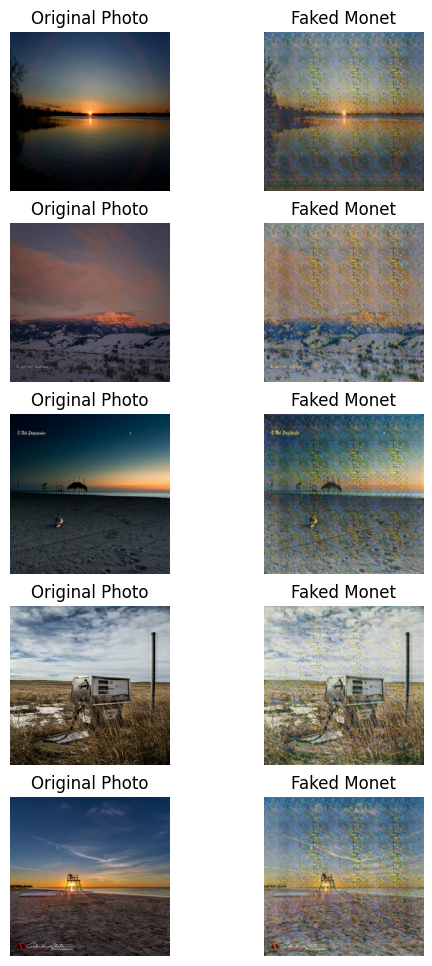

In [53]:
_, ax = plt.subplots(5, 2, figsize=(6, 12))
photo_ds = photo_ds.shuffle(buffer_size=1000, seed=42)
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Original Photo")
    ax[i, 1].set_title("Faked Monet")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Conclusion 
Does the conclusion include the following:
- Basic reiteration of results
- Discussion of learning and takeaways
- Discussion of why something didn’t work.
- Suggestions for ways to improve.

- Results:
    - Was able to create a CycleGAN, generator and discriminator, to create images that are close enough to Monets.
- Learnings:
    - Some of the real Monets looked too similar to each other which caused a concern in training. This is fine as we're trying to replicate the art-style of Monet, not the actual image contents. 
    - There's a certain brush style with Monets that were carried over to the generated ones.
- What didn't work
    - Making the discriminator simpler, less layers, made it much more difficult to perceive reals/fakes, making it so the generator could get away with not doing much to the original image. The discriminator needs to be complex in layers as the generator in order for both of them to "learn" faster to our desired goal of Monet fakes.
- Ways to improve:
    - Use grid search or random search for more diverse sampling approach. 
    - Use Optuna or Ray Tune, hyperparamter optimization frameworks, to simplify and speed up the tuning process.